# Fractal compression

In [1]:
import librosa
import librosa.core.spectrum
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import math
from scipy import ndimage
from scipy import optimize
import matplotlib.image as mpimg

In [2]:
# read file (stereo)
original, fs = librosa.core.load("../data/trance.wav", sr=44100, mono=False)

In [3]:
# process
spectrogram = [librosa.core.stft(original[0], n_fft=1024), librosa.core.stft(original[1], n_fft=1024)]
abs_spectrogram = np.abs(spectrogram)

In [4]:
# quantisation
quantised_spectrogram = (10 * np.sqrt(abs_spectrogram, out=np.zeros_like(abs_spectrogram), where=(abs_spectrogram != 0))).round()

(2, 513, 4101)

In [29]:
# Code taken from https://github.com/pvigier/fractal-image-compression
def get_greyscale_image(img):
    return np.mean(img[:,:,:2], 2)

def extract_rgb(img):
    return img[:,:,0], img[:,:,1], img[:,:,2]

def assemble_rbg(img_r, img_g, img_b):
    shape = (img_r.shape[0], img_r.shape[1], 1)
    return np.concatenate((np.reshape(img_r, shape), np.reshape(img_g, shape), 
        np.reshape(img_b, shape)), axis=2)

def reduce(img, factor):
    result = np.zeros((img.shape[0] // factor, img.shape[1] // factor))
    for i in range(result.shape[0]):
        for j in range(result.shape[1]):
            result[i,j] = np.mean(img[i*factor:(i+1)*factor,j*factor:(j+1)*factor])
    return result

def rotate(img, angle):
    return ndimage.rotate(img, angle, reshape=False)

def flip(img, direction):
    return img[::direction,:]

def apply_transformation(img, direction, angle, contrast=1.0, brightness=0.0):
    return contrast*rotate(flip(img, direction), angle) + brightness

def find_contrast_and_brightness1(D, S):
    # Fix the contrast and only fit the brightness
    contrast = 0.75
    brightness = (np.sum(D - contrast*S)) / D.size
    return contrast, brightness 

def find_contrast_and_brightness2(D, S):
    # Fit the contrast and the brightness
    A = np.concatenate((np.ones((S.size, 1)), np.reshape(S, (S.size, 1))), axis=1)
    b = np.reshape(D, (D.size,))
    x, _, _, _ = np.linalg.lstsq(A, b)
    #x = optimize.lsq_linear(A, b, [(-np.inf, -2.0), (np.inf, 2.0)]).x
    return x[1], x[0]

def generate_all_transformed_blocks(img, source_size, destination_size, step):
    factor = source_size // destination_size
    transformed_blocks = []
    for k in range((img.shape[0] - source_size) // step + 1):
        for l in range((img.shape[1] - source_size) // step + 1):
            # Extract the source block and reduce it to the shape of a destination block
            S = reduce(img[k*step:k*step+source_size,l*step:l*step+source_size], factor)
            # Generate all possible transformed blocks
            transformed_blocks.append((k, l, 1, 0, apply_transformation(S, 1, 0)))
            #for direction, angle in candidates:
            #    transformed_blocks.append((k, l, direction, angle, apply_transformation(S, direction, angle)))
    return transformed_blocks

def compress(img, source_size, destination_size, step):
    transformations = []
    transformed_blocks = generate_all_transformed_blocks(img, source_size, destination_size, step)
    i_count = img.shape[0] // destination_size
    j_count = img.shape[1] // destination_size
    for i in range(i_count):
        transformations.append([])
        print(f"{i}/{i_count}")
        for j in range(j_count):
            transformations[i].append(None)
            min_d = float('inf')
            # Extract the destination block
            D = img[i*destination_size:(i+1)*destination_size,j*destination_size:(j+1)*destination_size]
            # Test all possible transformations and take the best one
            for k, l, direction, angle, S in transformed_blocks:
                contrast, brightness = find_contrast_and_brightness2(D, S)
                S = contrast*S + brightness
                d = np.sum(np.square(D - S))
                if d < min_d:
                    min_d = d
                    transformations[i][j] = (k, l, direction, angle, contrast, brightness)
    return transformations

def decompress(transformations, source_size, destination_size, step, nb_iter=8):
    factor = source_size // destination_size
    height = len(transformations) * destination_size
    width = len(transformations[0]) * destination_size
    iterations = [np.random.randint(0, 256, (height, width))]
    cur_img = np.zeros((height, width))
    for i_iter in range(nb_iter):
        # print(i_iter)
        for i in range(len(transformations)):
            for j in range(len(transformations[i])):
                # Apply transform
                k, l, flip, angle, contrast, brightness = transformations[i][j]
                S = reduce(iterations[-1][k*step:k*step+source_size,l*step:l*step+source_size], factor)
                D = apply_transformation(S, flip, angle, contrast, brightness)
                cur_img[i*destination_size:(i+1)*destination_size,j*destination_size:(j+1)*destination_size] = D
        iterations.append(cur_img)
        cur_img = np.zeros((height, width))
    return iterations


def plot_iterations(iterations, target=None):
    # Configure plot
    plt.figure()
    nb_row = math.ceil(np.sqrt(len(iterations)))
    nb_cols = nb_row
    # Plot
    for i, img in enumerate(iterations):
        plt.subplot(nb_row, nb_cols, i+1)
        plt.imshow(img, cmap='gray', vmin=0, vmax=255, interpolation='none')
        if target is None:
            plt.title(str(i))
        else:
            # Display the RMSE
            plt.title(str(i) + ' (' + '{0:.2f}'.format(np.sqrt(np.mean(np.square(target - img)))) + ')')
        frame = plt.gca()
        frame.axes.get_xaxis().set_visible(False)
        frame.axes.get_yaxis().set_visible(False)
    plt.tight_layout()

# Parameters

directions = [1, -1]
angles = [0, 90, 180, 270]
candidates = [[direction, angle] for direction in directions for angle in angles]

# Tests

def test_greyscale():
    img = mpimg.imread('monkey.gif')
    img = get_greyscale_image(img)
    img = reduce(img, 4)
    plt.figure()
    plt.imshow(img, cmap='gray', interpolation='none')
    transformations = compress(img, 8, 4, 8)
    iterations = decompress(transformations, 8, 4, 8)
    plot_iterations(iterations, img)
    plt.show()


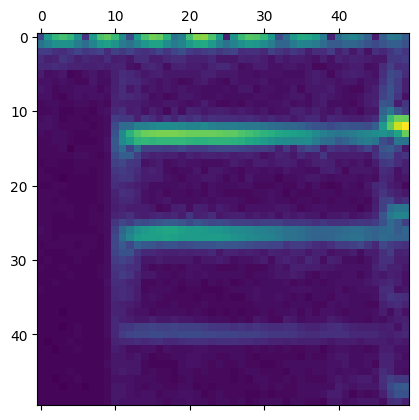

In [75]:
# Cut frequency spectrum and start from audio beginning
window = quantised_spectrogram[0, :50, 150:200]
plt.matshow(window)

In [76]:
# Compress
transformations = compress(window, 8, 4, 8)

0/12
1/12
2/12
3/12
4/12
5/12


/var/folders/sq/jtfxrmx95_j9gpqlvwrkwsvr0000gn/T/ipykernel_1791/1409158747.py:39: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x, _, _, _ = np.linalg.lstsq(A, b)


6/12
7/12
8/12
9/12
10/12
11/12


In [77]:
# Decompress
reproductions = decompress(transformations, 8, 4, 8, nb_iter=30)

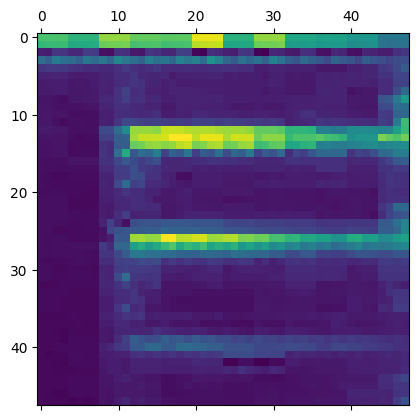

In [81]:
plt.matshow(reproductions[30])

In [ ]:
# For graphics
for i, r in enumerate(reproductions):
    if i % 5 == 0:
        print(i)
        plt.matshow(r)
        plt.axis("off")